# Model1 CNN
version 0.1.(a).2

## Implementation detals
- Input size: -1 x 128 x 128
- Output size: -1 x 3
<br></br>
- X: depth image
- Y: (x, y, d) of center point of mask
## Version Info
- Mapping from depth images to subject's center point coordinates
- Only Encoder
- Rewrote downside convolution

In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

## Model

In [23]:
class MyEncodeCNN(nn.Module):
    def __init__(self):
        super(MyEncodeCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=(1, 1), padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # Same Padding
            # In = 128 * 128 * 1
            # Out = 64 * 64 * 32
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=(1, 1), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # Same Padding
            # In = 64 * 64 * 32
            # Out = 32 * 32 * 64
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=(1, 1), padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # Same Padding
            # In = 32 * 32 * 64
            # Out = 16 * 16 * 128
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=(1, 1), padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            # Same Padding
            # In = 16 * 16 * 128
            # Out = 8 * 8 * 256
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=(1, 1), padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(inplace=True),
            # Same Padding
            # In = 8 * 8 * 256
            # Out = 4 * 4 * 512
        )
            

        self.layerfc = nn.Sequential(
            nn.Linear(8*8*256, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 3)
        )

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.layer1(x.view(-1, 1, 128, 128))
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # size_x = batch_size * 8 * 8 * 256
        x = self.dropout(x)
        x = self.layerfc(x.view(-1, 8 * 8 * 256))
        return x
    

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.encoder = MyEncodeCNN()

    def forward(self, x):
        z = self.encoder(x)
        return z

In [24]:
m1 = MyModel()
summary(m1, input_size=(1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 3]                    --
├─MyEncodeCNN: 1-1                       [1, 3]                    1,181,184
│    └─Sequential: 2-1                   [1, 32, 64, 64]           --
│    │    └─Conv2d: 3-1                  [1, 32, 128, 128]         320
│    │    └─BatchNorm2d: 3-2             [1, 32, 128, 128]         64
│    │    └─LeakyReLU: 3-3               [1, 32, 128, 128]         --
│    │    └─MaxPool2d: 3-4               [1, 32, 64, 64]           --
│    └─Sequential: 2-2                   [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-5                  [1, 64, 64, 64]           18,496
│    │    └─BatchNorm2d: 3-6             [1, 64, 64, 64]           128
│    │    └─LeakyReLU: 3-7               [1, 64, 64, 64]           --
│    │    └─MaxPool2d: 3-8               [1, 64, 32, 32]           --
│    └─Sequential: 2-3                   [1, 128, 16, 16]          --
│ 

## Dataset

In [25]:
datadir = '../Dataset/make02/'
print(os.listdir(datadir))

['x.npy', 'y.npy', '.ipynb_checkpoints']


In [32]:
# My Dataset

class MyDataset(Data.Dataset):
    def __init__(self, x_path, y_path, number=0):
        self.seeds = None
        self.data = self.load_data(x_path, y_path, number=number)
        print('loaded')

    def __getitem__(self, index):
        return self.data['x'][index], self.data['y'][index]

    def __len__(self):
        return self.data['x'].shape[0]

    def load_data(self, x_path, y_path, number):
        x = np.load(x_path)
        y = np.load(y_path)

        if x.shape[0] == y.shape[0]:
            total_count = x.shape[0]
        else:
            print(print("Unequal lengths of x: {} and y: {}!".format(x.shape, y.shape)))
            
        if number > 0:
            picked = np.random.choice(list(range(total_count)), size=number, replace=False)
            self.seeds = picked
            x = x[picked]
            y = y[picked]

        return {'x':x, 'y':y}
    

mydata = MyDataset(datadir + 'x.npy', datadir + 'y.npy')

train_size = int(len(mydata) * 0.7)
valid_size = int(len(mydata) * 0.2)
test_size = int(len(mydata)) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = Data.random_split(mydata, [train_size, valid_size, test_size])
print(train_size, valid_size, test_size)

train_loader = Data.DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = Data.DataLoader(valid_dataset, batch_size=8, shuffle=True)
test_loader = Data.DataLoader(test_dataset, batch_size=8, shuffle=True)

print(len(train_loader), len(valid_loader), len(test_loader))


loaded
2730 780 390
342 98 49


In [33]:
print(mydata.data['x'].shape)
print(mydata.data['y'].shape)

(3900, 128, 128)
(3900, 3)


In [28]:
torch.cuda.get_device_name(0)

'GeForce GTX TITAN X'

## Running gears

In [59]:
# Hyperparameters

class MyArgs:
    def __init__(self, epochs=10, learning_rate=0.001):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

args = MyArgs(epochs=100, learning_rate=0.0001)

In [34]:
# Model and Loss

model = MyModel().to(args.device)

criterion = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

train_loss = []
valid_loss = []
train_epochs_loss = []
valid_epochs_loss = []

# early_stopping = EarlyStopping(patience=args.patience,verbose=True)

In [60]:
# Training and Saving
start = time.time()

for epoch in range(args.epochs):
    model.train()
    train_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(train_loader,0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.float32).to(args.device)
        optimizer.zero_grad()
        outputs = model(data_x)
        loss = criterion(data_y, outputs)
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
        train_loss.append(loss.item())
        if idx%(len(train_loader)//2)==0:
            print("\repoch={}/{},{}/{}of train, loss={}".format(
            epoch, args.epochs, idx, len(train_loader),loss.item()), end='')
    train_epochs_loss.append(np.average(train_epoch_loss))
  
  #=====================valid============================
model.eval()
valid_epoch_loss = []
for idx,(data_x,data_y) in enumerate(valid_loader,0):
    data_x = data_x.to(torch.float32).to(args.device)
    data_y = data_y.to(torch.float32).to(args.device)
    outputs = model(data_x)
    loss = criterion(outputs,data_y)
    valid_epoch_loss.append(loss.item())
    valid_loss.append(loss.item())
valid_epochs_loss.append(np.average(valid_epoch_loss))

  #==================early stopping======================
  # early_stopping(valid_epochs_loss[-1],model=MyModel,path=r'')
  # if early_stopping.early_stop:
  #    print("Early stopping")
  #    break
  #====================adjust lr========================
lr_adjust = {
    2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
    10: 5e-7, 15: 1e-7, 20: 5e-8
}
  #if epoch in lr_adjust.keys():
  #    lr = lr_adjust[epoch]
  #    for param_group in optimizer.param_groups:
  #        param_group['lr'] = lr
  #    print('Updating learning rate to {}'.format(lr))

end = time.time()
print("\nTotal training time:", end-start, "sec")
print("Current args: epoch={}, lr={}".format(args.epochs, args.learning_rate))

epoch=99/100,171/342of train, loss=16.494108200073242
Total training time: 1673.4067528247833 sec
Current args: epoch=100, lr=0.0001


In [ ]:
torch.save(model.state_dict(), '../Models/v01a1_w.pth')

## Visualization of Training Process

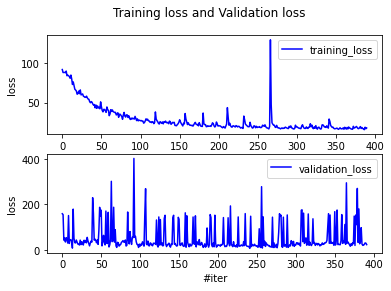

In [61]:
# Plot loss curves

%matplotlib inline
plt.clf()
plt.suptitle("Training loss and Validation loss")
plt.subplot(2, 1, 1)
plt.plot(train_epochs_loss[10:], 'b', label = 'training_loss')
plt.ylabel('loss')
plt.xlabel('#epoch')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(valid_loss, 'b', label = 'validation_loss')
plt.ylabel('loss')
plt.xlabel('#iter')
plt.legend()
#plt.savefig("loss_900epoch_down.jpg")

In [27]:
print(np.array(train_epochs_loss).shape, np.array(valid_epochs_loss).shape)
print(np.array(train_loss).shape, np.array(valid_loss).shape)

(600,) (2,)
(25800,) (26,)


## Estimation

(3900, 128, 128)
(3900, 3)


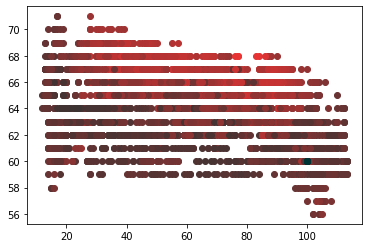

In [41]:
%matplotlib inline
datadir = '../Dataset/make02/'
gt_x = datadir + 'x.npy'
gt_y = datadir + 'y.npy'
sample_x = np.load(gt_x)
sample_y = np.load(gt_y)
print(sample_x.shape)
print(sample_y.shape)
for i in range(len(sample_y)):
    plt.scatter(sample_y[i][0], sample_y[i][1], color=(sample_y[i][2]/4000, 0.2, 0.2))
plt.show()

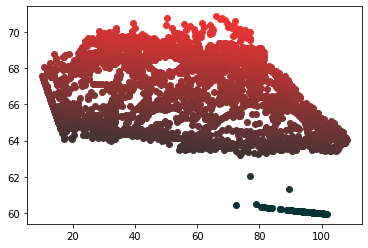

In [56]:
%matplotlib inline
for i in range(len(sample_x)):
    data = torch.tensor(sample_x[i], dtype=torch.float32, device=args.device)
    predictions = model(data)
    pred = predictions.cpu().detach().numpy()[0]
    if 
    plt.scatter(pred[0], pred[1], color=(np.abs(pred[2])/4000, 0.2, 0.2))
plt.show()

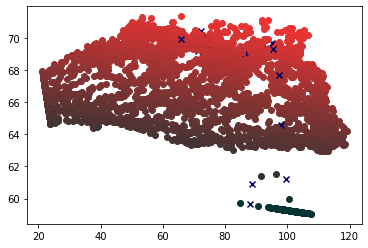

In [62]:
%matplotlib inline
def cosine_similarity(A, B):
    return np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))

for i in range(len(sample_x)):
    data = torch.tensor(sample_x[i], dtype=torch.float32, device=args.device)
    predictions = model(data)
    pred = predictions.cpu().detach().numpy()[0]
    if cosine_similarity(pred, sample_y[i]) >= 0.9:
        plt.scatter(pred[0], pred[1], color=(np.abs(pred[2])/4000, 0.2, 0.2))
    else:
        plt.scatter(pred[0], pred[1], marker='x', color=(0, 0, 0.4))
plt.show()